The cell below loads the data and computes the explanations.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle
import shap
import explainer

# Load data and create features
default_seed = 1
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "./Data/clean_data.pickle", "rb" ) )
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Focus only on loans with 36 months term and 13% interest rate (the most common)
fil_data = data[data.term == " 36 months"]
rate = 13
fil_data = fil_data[np.round(fil_data.int_rate) == rate]

# Remove other features
continuous_features.remove("int_rate")
continuous_features.remove("funded_amnt")
discrete_features.remove("term")

# Prepare data for modeling by discretizing categorical variables
X_continuous = fil_data[continuous_features].values
X_discrete = pd.get_dummies(fil_data[discrete_features], prefix_sep = "::")
# Drop the modes of the categorical variables
for feature, mode in zip(discrete_features, fil_data[discrete_features].mode().iloc[0]):
    X_discrete.drop(feature + "::" + mode, inplace=True, axis="columns")
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values
# For now, keep only the continuous features
#X = pd.DataFrame(np.concatenate((X_continuous, X_discrete), axis = 1), columns=continuous_features + discrete_features_dummies)
X = pd.DataFrame(X_continuous, columns=continuous_features)
y = fil_data.outcome.values
train = fil_data.train.values

# Train and predict
model = LogisticRegression(solver='liblinear')
model.fit(X[train], y[train])
probs = model.predict_proba(X[~train])[:, 1]
# Choose arbitrary threshold
threshold = 0.23
denied = threshold < probs

# Get default values
#default = np.concatenate((X[~train][continuous_features].mean(), X[~train][discrete_features_dummies].mode().iloc[0]))
default = X[~train][continuous_features].mean()

# Get SHAP explanations for the guys for whom credit was denied
sample = X[~train][denied]
def make_decision(data):
    return (model.predict_proba(data)[:, 1] > threshold).astype(float)

explain = shap.KernelExplainer(make_decision, default.values.reshape(1, -1))
shap_values = explain.shap_values(sample.values, nsamples=10000, l1_reg='aic')

def scoring_function(data):
    return model.predict_proba(data)[:, 1]

# Get evidence-based explanations
explain = explainer.Explainer(scoring_function, default, prune=False)
explanations = explain.explain(sample.values, thresholds=threshold)

 19%|███████████████▏                                                                  | 18/97 [00:04<00:18,  4.27it/s]C:\Users\ferlo\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:604: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=2.059e-06, previous alpha=2.059e-06, with an active set of 8 regressors.
  ConvergenceWarning)
 23%|██████████████████▌                                                               | 22/97 [00:05<00:23,  3.25it/s]C:\Users\ferlo\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:604: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=3.536e-06, previous alpha=2.960e-06, with an active set of 6 regressors.
  ConvergenceWarning)
 27%|█████████████████████▉                                                            | 2

Gets the top 4 explanations with the shortest euclidian distances and the least match in evidence-based explanations.

In [2]:
from sklearn.metrics.pairwise import euclidean_distances

# Get similarities
similarities = euclidean_distances(shap_values)

# Find guy with the most similar people
largest = 0
ix = -1
top = 4
for i in range(similarities.shape[0]):
    most_similar_ixs = similarities[ix, :].argsort()[:top]
    exps = explanations[i]
    i_largest = 0
    for j in most_similar_ixs:
        match = 0
        for e in exps:
            if e in explanations[j]:
                match += 1
        match /= len(exps)
        i_largest += (1-match) * (1 - similarities[i, j])
    if i_largest > largest:
        largest = i_largest
        ix = i  

# Get top most similar loans that were denied credit (and their explanations)
top_shap_ix = similarities[ix, :].argsort()[:top]
top_exp = [explanations[ix] for ix in top_shap_ix]

# Print features in the explanations
print("Explanations from the top")
for e in top_exp:
    print(e)
    
# Compare according to SHAP
print("Probabilities of default")
print(probs[denied][top_shap_ix])
print("Euclidian distance")
print(np.sort(similarities[ix, :])[:top])
print("Top features according to SHAP")
for ix in top_shap_ix:
    print(np.sort(shap_values[ix, :])[-5:][::-1])
    print(shap_values[ix, :].argsort()[-5:][::-1])

Explanations from the top
[[0], [2, 9], [2, 8], [2, 11], [1, 2], [2, 4, 10]]
[[0], [2, 9], [2, 8], [2, 6]]
[[2], [0], [8, 9], [3, 9], [9, 11], [9, 10], [1, 6, 9]]
[[0], [2], [8, 9], [3, 9], [9, 11], [1, 9], [9, 10], [6, 9], [7, 9], [3, 8], [8, 11], [1, 8], [8, 10]]
Probabilities of default
[0.23591602 0.23697978 0.2359721  0.2338517 ]
Euclidian distance
[0.         0.18056624 0.19107579 0.19294304]
Top features according to SHAP
[0.41994048 0.21636905 0.09454365 0.09454365 0.08501984]
[ 0  2  9  8 11]
[0.41455026 0.16455026 0.13994709 0.13994709 0.12645503]
[0 2 9 8 6]
[0.2760582  0.2760582  0.11335979 0.10939153 0.08558201]
[2 0 9 8 3]
[0.27238817 0.27238817 0.15647908 0.14738817 0.02953102]
[ 2  0  9  8 11]


In [3]:
full_explanations = explain.explain(sample.iloc[top_shap_ix].values, thresholds=threshold, max_ite=200)
for e in full_explanations:
    print(e)

[[0], [2, 9], [2, 8], [2, 11], [1, 2], [2, 4, 10]]
[[0], [2, 9], [2, 8], [2, 6]]
[[2], [0], [8, 9], [3, 9], [9, 11], [9, 10], [1, 6, 9], [3, 8], [8, 11], [8, 10]]
[[0], [2], [8, 9], [3, 9], [9, 11], [1, 9], [9, 10], [6, 9], [7, 9], [3, 8], [8, 11], [1, 8], [8, 10], [6, 8], [1, 3, 10, 11]]


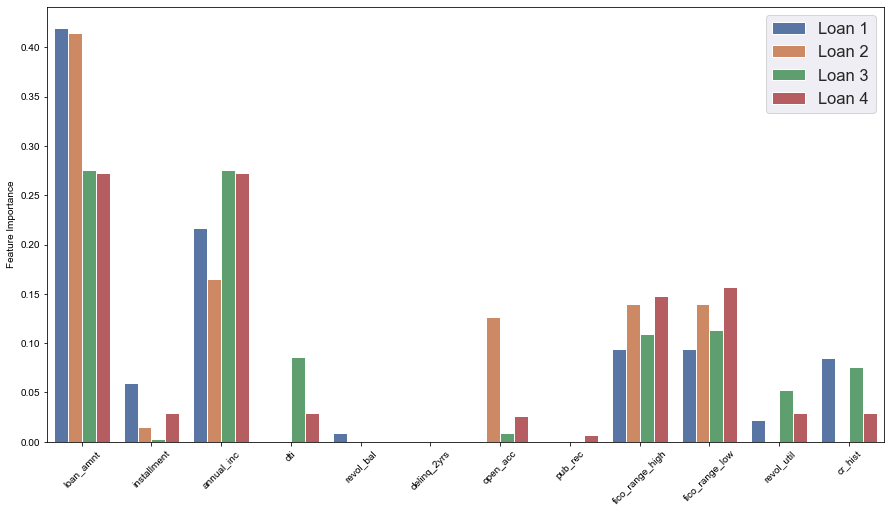

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
sns.set(font_scale=1.5)
ix_len = len(top_shap_ix)
f_len = shap_values.shape[1]
x = np.tile(continuous_features, ix_len)
y = shap_values[top_shap_ix, :].flatten()
hue = ["Loan {0}".format(i) for i in np.repeat(np.arange(ix_len) + 1, f_len).tolist()]
sns.barplot(x, y, hue, ax=ax)
ax.set_ylabel("Feature Importance")
plt.xticks(rotation=45)
plt.savefig("images/weights.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Get LaTex table
loan_ix = 3
top_ix = top_shap_ix[loan_ix]
ix_explanations = full_explanations[loan_ix]
print("\\begin{{tabular}}{{{0}}}".format("S"*(1+len(ix_explanations))))
print("\\toprule")
print('&'.join(["{Explanations $\\rightarrow$}"]+ ["{{{0}}}".format(i+ 1) for i in range(len(ix_explanations))]) + "\\\\")
print("\\midrule")
features = np.unique(np.array([item for sublist in ix_explanations for item in sublist]))
for f in features:
    line = ["{{${0}$}}".format(continuous_features[f].replace('_', '\_'))]
    for e in ix_explanations:
        if f in e:
            is_high = default[f] < sample.iloc[top_ix, f]
            change_needed = "{$\\uparrow$}" if is_high else "{$\\downarrow$}"
            line += [change_needed]
        else:
            line += [""]
    print("&".join(line) + "\\\\")
print("\\midrule") 
print("\\multicolumn{7}{l}{$\\uparrow$ means feature is too large to grant credit.} \\\\")    
print("\\multicolumn{7}{l}{$\\downarrow$ means feature is too small to grant credit.} \\\\")
print("\\bottomrule")    
print("\\end{tabular}")

\begin{tabular}{SSSSSSSSSSSSSSSS}
\toprule
{Explanations $\rightarrow$}&{1}&{2}&{3}&{4}&{5}&{6}&{7}&{8}&{9}&{10}&{11}&{12}&{13}&{14}&{15}\\
\midrule
{$loan\_amnt$}&{$\uparrow$}&&&&&&&&&&&&&&\\
{$installment$}&&&&&&{$\uparrow$}&&&&&&{$\uparrow$}&&&{$\uparrow$}\\
{$annual\_inc$}&&{$\downarrow$}&&&&&&&&&&&&&\\
{$dti$}&&&&{$\uparrow$}&&&&&&{$\uparrow$}&&&&&{$\uparrow$}\\
{$open\_acc$}&&&&&&&&{$\uparrow$}&&&&&&{$\uparrow$}&\\
{$pub\_rec$}&&&&&&&&&{$\uparrow$}&&&&&&\\
{$fico\_range\_high$}&&&{$\downarrow$}&&&&&&&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&\\
{$fico\_range\_low$}&&&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&{$\downarrow$}&&&&&&\\
{$revol\_util$}&&&&&&&{$\uparrow$}&&&&&&{$\uparrow$}&&{$\uparrow$}\\
{$cr\_hist$}&&&&&{$\downarrow$}&&&&&&{$\downarrow$}&&&&{$\downarrow$}\\
\midrule
\multicolumn{7}{l}{$\uparrow$ means feature is too large to grant credit.} \\
\multicolumn{7}{l}{$\downarrow$ means feature 

In [6]:
# Print all explanations
for i_ix, top_ix in enumerate(top_shap_ix):
    for i_exp, explanation in enumerate(full_explanations[i_ix]):
        print("Loan {0}, Explanation {1}:".format(i_ix + 1, i_exp+ 1))
        for i_f in explanation:
            feature = continuous_features[i_f]
            original_val = np.round(sample.iloc[top_ix, i_f])
            def_val = np.round(default[i_f])
            print("    Change feature {0} from {1} to {2}: ".format(feature, original_val, def_val))

Loan 1, Explanation 1:
    Change feature loan_amnt from 28000.0 to 11878.0: 
Loan 1, Explanation 2:
    Change feature annual_inc from 60000.0 to 69065.0: 
    Change feature fico_range_low from 670.0 to 686.0: 
Loan 1, Explanation 3:
    Change feature annual_inc from 60000.0 to 69065.0: 
    Change feature fico_range_high from 674.0 to 690.0: 
Loan 1, Explanation 4:
    Change feature annual_inc from 60000.0 to 69065.0: 
    Change feature cr_hist from 92.0 to 184.0: 
Loan 1, Explanation 5:
    Change feature installment from 940.0 to 400.0: 
    Change feature annual_inc from 60000.0 to 69065.0: 
Loan 1, Explanation 6:
    Change feature annual_inc from 60000.0 to 69065.0: 
    Change feature revol_bal from 9592.0 to 14417.0: 
    Change feature revol_util from 67.0 to 55.0: 
Loan 2, Explanation 1:
    Change feature loan_amnt from 27600.0 to 11878.0: 
Loan 2, Explanation 2:
    Change feature annual_inc from 60000.0 to 69065.0: 
    Change feature fico_range_low from 665.0 to 686.